<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/C%C3%B3pia_de_CV_Project2_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tqdm

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile


from PIL import Image
import zipfile

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [4]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 25.53 MiB/s, done.
Resolving deltas: 100% (10/10), done.
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json
images				     __MACOSX		   sample_data


In [68]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# Binary Classification DataFrame
df_binary = df.copy()
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

# Display DataFrame details
print("*************** Binary Classification DataFrame ***************")
print(df_binary.head())
print("Total rows:", df_binary.shape[0])

train_ratio = 0.9
test_ratio = 0.1
train_data, test_data = train_test_split(df_binary, test_size=test_ratio, train_size=train_ratio, random_state=2, stratify=df_binary['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


*************** Binary Classification DataFrame ***************
         image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
Total rows: 20000


In [69]:
"""
train_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
"""



'\ntrain_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])\ntrain_data.reset_index(drop=True, inplace=True)\ntest_data.reset_index(drop=True, inplace=True)\n'

ESTÁ IGUAL AO DO VITOR TEMOS QUE MUDAR DAQUI PARA BAIXO

In [70]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="RGB"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

"""
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
"""


'\nclass MyImageDataset(data.Dataset):\n    def __init__(self, metadata, transform=None):\n        self.img_labels = metadata["anomaly_class"].values\n        self.img_paths = metadata["image_filepath"].values\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx\n        img_path = self.img_paths[idx]\n        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB\n        label = self.img_labels[idx]\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image, torch.tensor(label, dtype=torch.long)\n'

In [71]:
# Transformações
transform = transforms.Compose([

    transforms.ToTensor(),  # Converte para tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza
])

# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=transform)
test_dataset = MyImageDataset(metadata=test_data, transform=transform)

# DataLoaders
batch_size = 32
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



torch.Size([3, 40, 24])


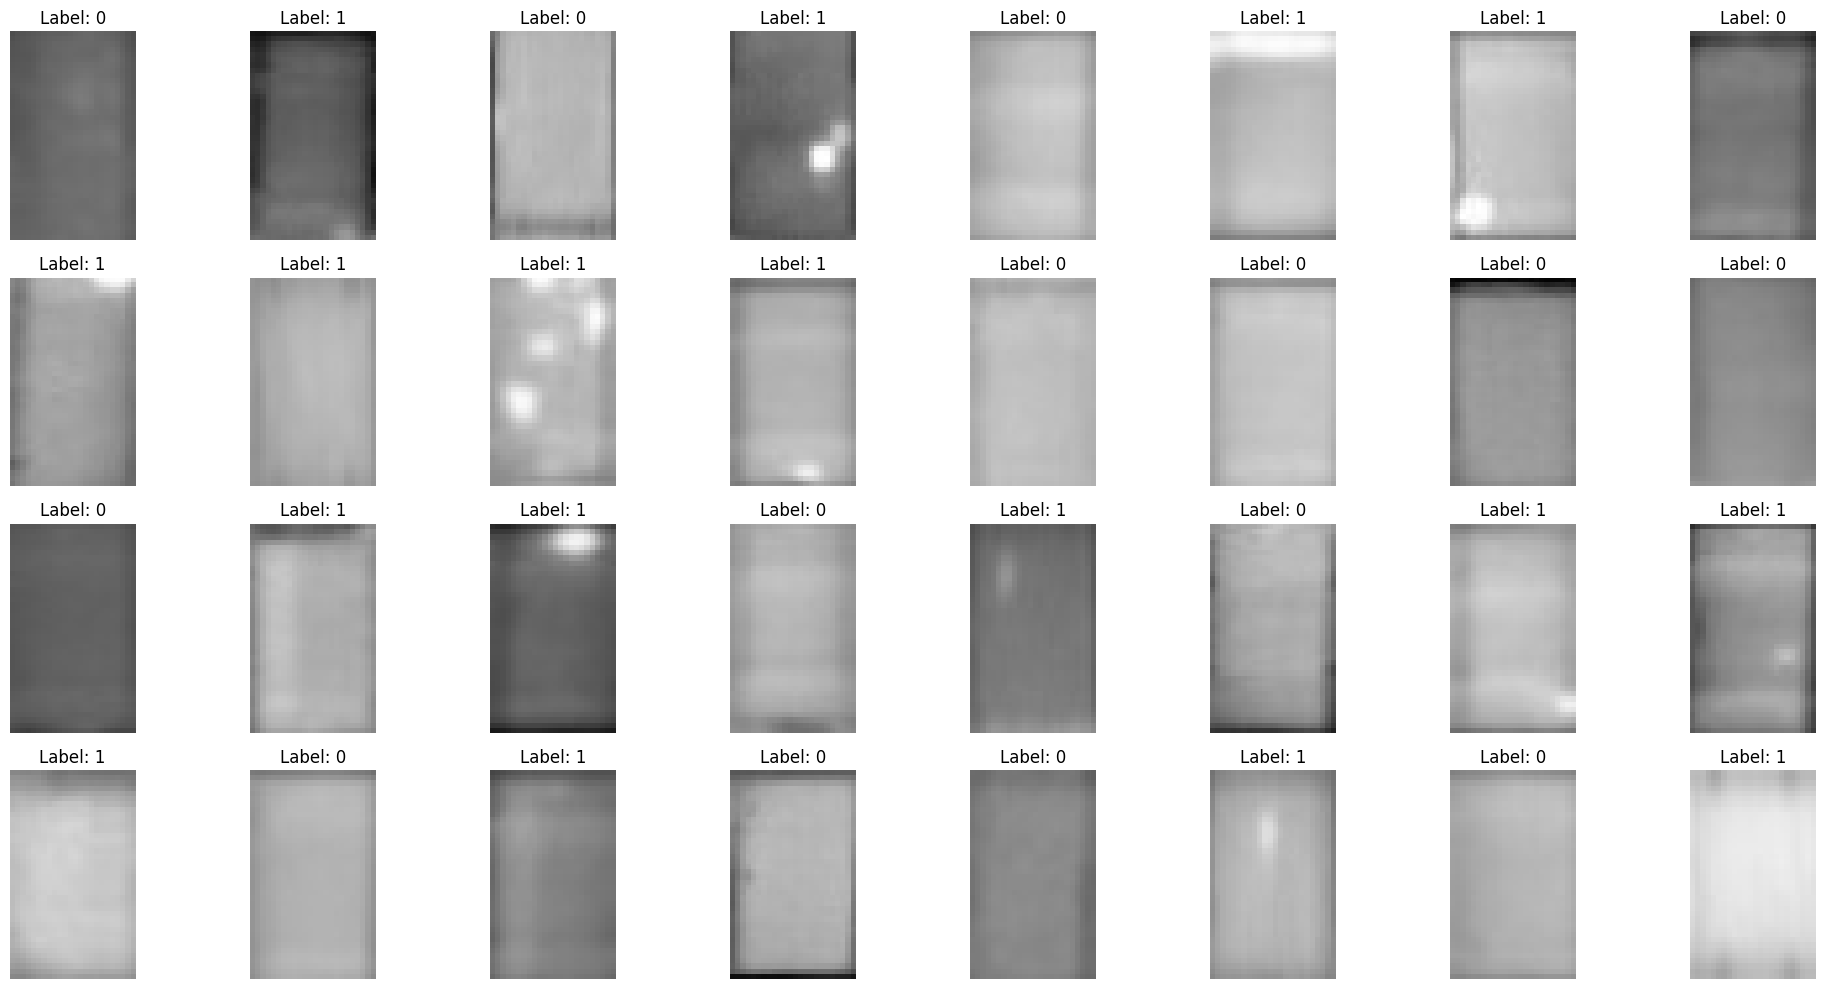

In [72]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()







In [73]:

#Mesmo da prática
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(3, 64, 5)  # Kernel size 5x5
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 5)  # Kernel size 5x5
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pool layer (2x2)

        self.dropout1 = nn.Dropout2d(0.2)  # Using dropout after convolutions

        self.conv3 = nn.Conv2d(128, 256, 3)  # Kernel size 3x3 (adjusted for valid output size)
        self.bn3 = nn.BatchNorm2d(256)

        # Calculating the correct input size for the fully connected layer
        # After conv1 + pool1: (64, 18, 10)
        # After conv2 + pool2: (128, 7, 3)
        # After conv3: (256, 5, 1)

        self.fc1 = nn.Linear(256 * 5 * 1, 1024)  # Adjusted based on new dimensions
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 2)  # 2 outputs, keep the 2 as there are only two outputs

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))  # Use the correct batch norm layer (bn3 for conv3)

        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)  # Flatten to [batch_size, 256*5*1]

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout1(x)  # Use dropout1 as defined
        x = self.fc4(x)

        return x

model = Network()
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9)

In [74]:
from torch.autograd import Variable

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adicionando a barra de progresso para os epochs

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adicionando a barra de progresso para os batches

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [75]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


In [76]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader=train_loader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 20,
                                                    path_model = str("./myModel_best_A.pth"),
                                                    verbatim = True)

Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epochs:   5%|▌         | 1/20 [00:13<04:21, 13.76s/epoch]

Best Epoch # 0  Loss= 0.49155677553286137  Accu= 0.7583259325044405


Epochs:  10%|█         | 2/20 [00:27<04:05, 13.66s/epoch]

Best Epoch # 1  Loss= 0.36607663104472743  Accu= 0.8420293072824157


Epochs:  15%|█▌        | 3/20 [00:40<03:50, 13.55s/epoch]

Best Epoch # 2  Loss= 0.315208604780967  Accu= 0.8660634991119005


Epochs:  20%|██        | 4/20 [00:54<03:38, 13.63s/epoch]

Best Epoch # 3  Loss= 0.2803180624150256  Accu= 0.8860457371225577


Epochs:  25%|██▌       | 5/20 [01:07<03:23, 13.54s/epoch]

Best Epoch # 4  Loss= 0.25802339061591806  Accu= 0.8973690053285968


Epochs:  30%|███       | 6/20 [01:21<03:08, 13.49s/epoch]

Best Epoch # 5  Loss= 0.23684326863680596  Accu= 0.9056949378330373


Epochs:  35%|███▌      | 7/20 [01:34<02:55, 13.47s/epoch]

Best Epoch # 6  Loss= 0.21716108277678278  Accu= 0.9152420071047958


Epochs:  40%|████      | 8/20 [01:48<02:41, 13.48s/epoch]

Best Epoch # 7  Loss= 0.2001398621262655  Accu= 0.9217917406749556


Epochs:  45%|████▌     | 9/20 [02:01<02:28, 13.49s/epoch]

Best Epoch # 8  Loss= 0.187500268819727  Accu= 0.9280639431616341


Epochs:  50%|█████     | 10/20 [02:15<02:14, 13.43s/epoch]

Best Epoch # 9  Loss= 0.17672823426407988  Accu= 0.9325044404973357


Epochs:  55%|█████▌    | 11/20 [02:28<02:01, 13.52s/epoch]

Best Epoch # 10  Loss= 0.16086643008551632  Accu= 0.9387766429840142


Epochs:  60%|██████    | 12/20 [02:42<01:48, 13.51s/epoch]

Best Epoch # 11  Loss= 0.1506472947886528  Accu= 0.9421070159857904


Epochs:  65%|██████▌   | 13/20 [02:55<01:34, 13.47s/epoch]

Best Epoch # 12  Loss= 0.13723559142131736  Accu= 0.9489342806394316


Epochs:  70%|███████   | 14/20 [03:08<01:20, 13.45s/epoch]

Best Epoch # 13  Loss= 0.12892847553021267  Accu= 0.95148756660746


Epochs:  75%|███████▌  | 15/20 [03:22<01:06, 13.40s/epoch]

Best Epoch # 14  Loss= 0.12162124468460282  Accu= 0.9553730017761989


Epochs:  80%|████████  | 16/20 [03:35<00:53, 13.38s/epoch]

Best Epoch # 15  Loss= 0.1100042293007034  Accu= 0.95848134991119


Epochs:  85%|████████▌ | 17/20 [03:49<00:40, 13.43s/epoch]

Best Epoch # 16  Loss= 0.1036225129249729  Accu= 0.9626998223801065


Epochs:  90%|█████████ | 18/20 [04:02<00:26, 13.48s/epoch]

Best Epoch # 17  Loss= 0.09660710180409875  Accu= 0.9641984902309059


Epochs:  95%|█████████▌| 19/20 [04:16<00:13, 13.48s/epoch]

Best Epoch # 18  Loss= 0.08888206597199237  Accu= 0.9686389875666075


Epochs: 100%|██████████| 20/20 [04:29<00:00, 13.49s/epoch]

Best Epoch # 19  Loss= 0.08270934754387074  Accu= 0.9704706927175843


In [77]:
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)

Loss = 0.25963155932665344   Accuracy= 0.9325396825396826
